# Demonstration: Memory-efficient Learned Design (MELD)

**author**: Michael Kellman

**date**: 17 April 2019

## System Information

**Imaging Model**: 

\begin{align}
    \mathbf{y} = \mathbf{F}^H \mathbf{H} \mathbf{F} \mathbf{x} + \mathbf{n}
\end{align}

**Inverse Model**:

\begin{align}
     \mathbf{x}^{\star} = \arg\underset{\mathbf{x}}{\min} \|\mathbf{F}^H \mathbf{H} \mathbf{F} \mathbf{x} - \mathbf{y}\|^2_2 + \lambda \left( \|\mathbf{W}\mathbf{x}\|_1 + \beta \|\mathbf{W}\mathbf{x}\|_2^2 \right)
\end{align}

**Reconstruction**: Proximal Gradient Descent Algorithm

**Learnable Parameters**: stepsize (alpha) and regularization parameter (lambda)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# import modules
import numpy as np
from skimage import data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as ag
import time

# import library dependencies
import sys
sys.path.append('../utilities/')
sys.path.append('../models/')
sys.path.append('../meld/')
from pytorch_complex import *
from utility import *
from deconv import *
from pytorch_proximal import *
from meld import *

# set types
dtype = torch.float32
np_dtype = np.float32
eps = np.finfo(np_dtype).eps

## Setup Graphical Processing Unit

In [2]:
gpu_device = 1
torch.cuda.set_device(gpu_device)
device = torch.device("cuda:"+str(gpu_device) if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_properties(gpu_device)

_CudaDeviceProperties(name='TITAN Xp', major=6, minor=1, total_memory=12196MB, multi_processor_count=30)

## Load image and blur kernel

<IPython.core.display.Javascript object>


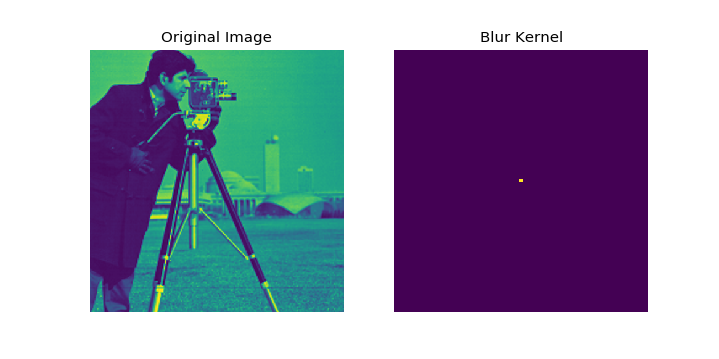

(-0.5, 411.5, 425.5, -0.5)

In [3]:
# setup image
img = data.camera().astype(np_dtype)
img = img[75:501,100:526]
Np = img.shape

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# setup blur kernel
from scipy.ndimage.filters import gaussian_filter
kernel = np.zeros(Np)
# kernel[Np[0]//2,Np[1]//2] = 1
# kernel = np.fft.fftshift(gaussian_filter(kernel, sigma=2)).astype(np_dtype)
kernel[Np[0]//2 - 3:Np[0]//2 + 3, Np[1]//2 - 3:Np[1]//2 + 3] = 1
kernel = np.fft.fftshift(kernel).astype(np_dtype)
plt.subplot(122)
plt.imshow(np.fft.ifftshift(kernel))
plt.title('Blur Kernel')
plt.axis('off')



## Gradient Model | Proximal Model | Network | Learning Class

In [4]:
# gradient model
img_t = torch.from_numpy(img).to(device)
kernel_t = torch.from_numpy(kernel).to(device)
alpha_t = torch.tensor([5e-2],device=device).type(dtype)
grad = Deblur(Np, img_t, kernel_t, alpha_t, T=8, noise_level=0, device=device).to(device)

# proximal model (wavelet soft thresholding)
thr = torch.tensor([1e-3],device=device).type(dtype)
alpha = torch.tensor([1e-6],device=device).type(dtype)
prox = WaveletSoftThr(Np,thr,alpha,testFlag=True,device=device)
prox.to(device)

# setup network
pgd_layer = PGD(grad,prox)
Nlayers = 500
network = genNetwork(pgd_layer,Nlayers)

# setup learning
x0 = torch.zeros_like(img_t)
gpu_memory_limit = 12196 # 12196 MB on Nvidia Titan X (Pascal)
unrolled_model = unroll(network, x0, gpu_memory_limit, device)

In [5]:
print([p_ for p_ in network.parameters()])

[Parameter containing:
tensor([0.0500], device='cuda:1', requires_grad=True), Parameter containing:
tensor([0.0010], device='cuda:1', requires_grad=True)]


## Conventional Backpropagation

In [6]:
x0 = torch.zeros(Np,device=device,dtype=dtype).requires_grad_(True)

torch.cuda.empty_cache()
startmem = torch.cuda.memory_cached(gpu_device)
starttime = time.time()

# evaluate network
out,X = feedforward(network,x0,interFlag=False)

loss = torch.sum((out-img_t)**2)
loss.backward()

endmem = torch.cuda.memory_cached(gpu_device)
endtime = time.time()

cbp_time = endtime - starttime
cbp_memory = endmem - startmem

In [7]:
print('Conventional Backpropagation')
print('Time(s):', cbp_time)
print('Memory(MB):', cbp_memory / 1024**2)

Conventional Backpropagation
Time(s): 6.84533429145813
Memory(MB): 6348.375


## Memory-efficient Learning (w/o checkpointing)

In [8]:
# gradient model
img_t = torch.from_numpy(img).to(device)
kernel_t = torch.from_numpy(kernel).to(device)
alpha_t = torch.tensor([5e-2],device=device).type(dtype)
grad = Deblur(Np, img_t, kernel_t, alpha_t, T=8, noise_level=0, device=device).to(device)

# proximal model (wavelet soft thresholding)
thr = torch.tensor([1e-3],device=device).type(dtype)
alpha = torch.tensor([1e-6],device=device).type(dtype)
prox = WaveletSoftThr(Np,thr,alpha,testFlag=True,device=device)
prox.to(device)

# setup network
pgd_layer = PGD(grad,prox)
Nlayers = 500
network = genNetwork(pgd_layer,Nlayers)

x0 = torch.zeros(Np,device=device,dtype=dtype).requires_grad_(False)
unrolled_model = unroll(network, x0, 3000, device)

# evaluate time and memory
torch.cuda.empty_cache()
startmem = torch.cuda.memory_cached(device)
starttime = time.time()

xN,loss,Xf,Xb = unrolled_model(x0,img_t,interFlag=False, testFlag=True)

endmem = torch.cuda.memory_cached(device) 
endtime = time.time()

mel_memory = endmem - startmem
mel_time = endtime - starttime

# evaluate accuracy
xN,loss,Xf,Xb = unrolled_model(x0, img_t ,interFlag=True, testFlag=True)
mel_acc = torch.mean((Xf-Xb)**2,dim=(1,2))



Requires memory-efficient learning!
Checkpointing every: 4


Memory-efficient Learning
Time(s): 10.259397983551025
Memory(MB): 107.875


<IPython.core.display.Javascript object>


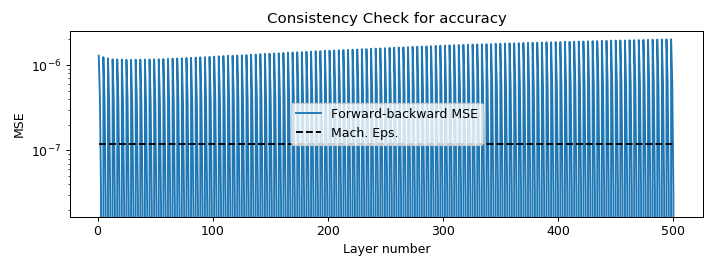

In [9]:
print('Memory-efficient Learning')
print('Time(s):', mel_time)
print('Memory(MB):', mel_memory / 1024**2)

plt.figure(figsize=(8,3))
plt.semilogy(np.linspace(1,Nlayers+1,Nlayers),mel_acc.detach().cpu().numpy(),label='Forward-backward MSE')
plt.semilogy([1,Nlayers],[eps,eps],'k--',label='Mach. Eps.')
plt.title('Consistency Check for accuracy')
plt.xlabel('Layer number')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()

## Memory-efficient Learning (w/ checkpointing)

In [10]:
# gradient model
img_t = torch.from_numpy(img).to(device)
kernel_t = torch.from_numpy(kernel).to(device)
alpha_t = torch.tensor([5e-2],device=device).type(dtype)
grad = Deblur(Np, img_t, kernel_t, alpha_t, T=8, noise_level=0, device=device).to(device)

# proximal model (wavelet soft thresholding)
thr = torch.tensor([1e-3],device=device).type(dtype)
alpha = torch.tensor([1e-6],device=device).type(dtype)
prox = WaveletSoftThr(Np,thr,alpha,testFlag=True,device=device)
prox.to(device)

# setup network
pgd_layer = PGD(grad,prox)
Nlayers = 500
network = genNetwork(pgd_layer,Nlayers)

x0 = torch.zeros(Np,device=device,dtype=dtype).requires_grad_(False)
gpu_memory_limit = 200
unrolled_model = unroll(network, x0, gpu_memory_limit, device)

# evaluate time and memory
torch.cuda.empty_cache()
startmem = torch.cuda.memory_cached(device)
starttime = time.time()

xN,loss,Xf,Xb = unrolled_model(x0, img_t, interFlag=False, testFlag=True)

endmem = torch.cuda.memory_cached(device)
endtime = time.time()

melcp_memory = endmem - startmem
melcp_time = endtime - starttime

# evaluate accuracy
xN,loss,Xf,Xb = unrolled_model(x0, img_t ,interFlag=True, testFlag=True)
melcp_acc = torch.mean((Xf-Xb)**2,dim=(1,2))

Requires memory-efficient learning!
Checkpointing every: 52


Memory-efficient Learning (w/ checkpointing)
Time(s): 14.328286170959473
Memory(MB): 29.875


<IPython.core.display.Javascript object>


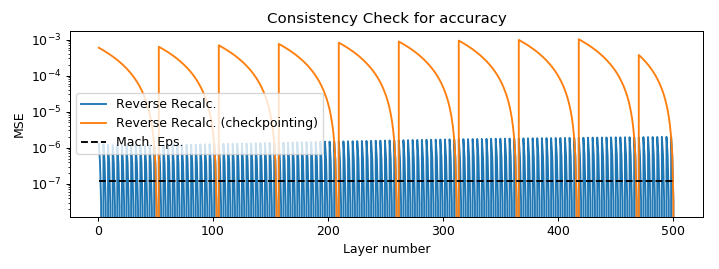

In [11]:
print('Memory-efficient Learning (w/ checkpointing)')
print('Time(s):', melcp_time)
print('Memory(MB):', melcp_memory / 1024**2)

plt.figure(figsize=(8,3))
plt.semilogy(np.linspace(1,Nlayers+1,Nlayers),mel_acc.detach().cpu().numpy(),label='Reverse Recalc.')
plt.semilogy(np.linspace(1,Nlayers+1,Nlayers),melcp_acc.detach().cpu().numpy(),label='Reverse Recalc. (checkpointing)')
plt.semilogy([1,Nlayers],[eps,eps],'k--',label='Mach. Eps.')
plt.title('Consistency Check for accuracy')
plt.xlabel('Layer number')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()

In [12]:
len(unrolled_model.cpList)

9